In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
data <- read_csv("atp2017-2019.csv")

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [4]:
data <- data%>%
    select(tourney_date, winner_name, winner_hand, winner_ht, winner_ioc, winner_age, winner_rank)%>%
    filter(!is.na(winner_ht), !is.na(winner_rank), !is.na(winner_age), !is.na(winner_ioc), !is.na(winner_hand))%>%
    mutate(winner_hand = as_factor(winner_hand), winner_ioc = as_factor(winner_ioc), winner_rank = as.double(winner_rank))%>%
    distinct()

In [5]:
data <- data%>%
    group_by(winner_name, winner_hand, winner_ht, winner_ioc)%>%
    summarize(number_of_wins = n(), winner_avg_age = mean(winner_age), winner_avg_rank = mean(winner_rank))%>%
    select(winner_name, winner_hand, winner_ht, winner_ioc, winner_avg_age, winner_avg_rank)
data <- mutate(data, winner_avg_age = round(winner_avg_age, 2))
data <- mutate(data, winner_avg_rank = round(winner_avg_rank, 2))
head(data, 6)


`summarise()` regrouping output by 'winner_name', 'winner_hand', 'winner_ht' (override with `.groups` argument)



winner_name,winner_hand,winner_ht,winner_ioc,winner_avg_age,winner_avg_rank
<chr>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
Adrian Mannarino,L,183,FRA,30.00,42.29
Albert Ramos,L,188,ESP,30.27,46.52
Alessandro Giannessi,L,183,ITA,27.39,137.00
Alexander Zverev,R,198,GER,21.11,7.51
Aljaz Bedene,R,181,SLO,28.80,66.42
Andreas Seppi,R,190,ITA,34.23,65.03


In [14]:
set.seed(9999) 

data_split <- initial_split(data, prop = 0.75, strata = winner_avg_rank)
data_train <- training(data_split)
data_test <- testing(data_split)

head(data_train, 6)

winner_name,winner_hand,winner_ht,winner_ioc,winner_avg_age,winner_avg_rank
<chr>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
Adrian Mannarino,L,183,FRA,30.00,42.29
Albert Ramos,L,188,ESP,30.27,46.52
Alessandro Giannessi,L,183,ITA,27.39,137.00
Aljaz Bedene,R,181,SLO,28.80,66.42
Andrej Martin,R,180,SVK,28.72,139.67
Andy Murray,R,190,GBR,31.05,209.12


In [7]:
data_train_summarize <- data_train%>%
    tibble(number_of_players = 81, number_of_right_handed = 71, number_of_left_handed = 10, max_height = max(winner_ht), min_height = min(winner_ht), mean_height = mean(winner_ht),
          number_of_nationalities = 33, max_age = max(winner_avg_age), min_age = min(winner_avg_age), mean_age = mean(winner_avg_age), top = "Rafael Nadal", bottom = "James Duckworth")%>%
    select(number_of_players:bottom)%>%
    slice(1)
data_train_summarize

number_of_winner_hand <- data_train%>%
    group_by(winner_hand)%>%
    summarize(n())

nationality_analysis <- data_train%>%
    group_by(winner_ioc)%>%
    summarize(number = n())%>%
    nrow()

ranking <- data_train%>%
    group_by(winner_name)%>%
    summarize(winner_avg_rank)%>%
    arrange(winner_avg_rank)%>%
    slice(1, 81)

number_of_players,number_of_right_handed,number_of_left_handed,max_height,min_height,mean_height,number_of_nationalities,max_age,min_age,mean_age,top,bottom
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
81,71,10,208,170,185.75,33,39.08,23.06,30.02869,Rafael Nadal,James Duckworth


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



`summarise()` ungrouping output (override with `.groups` argument)



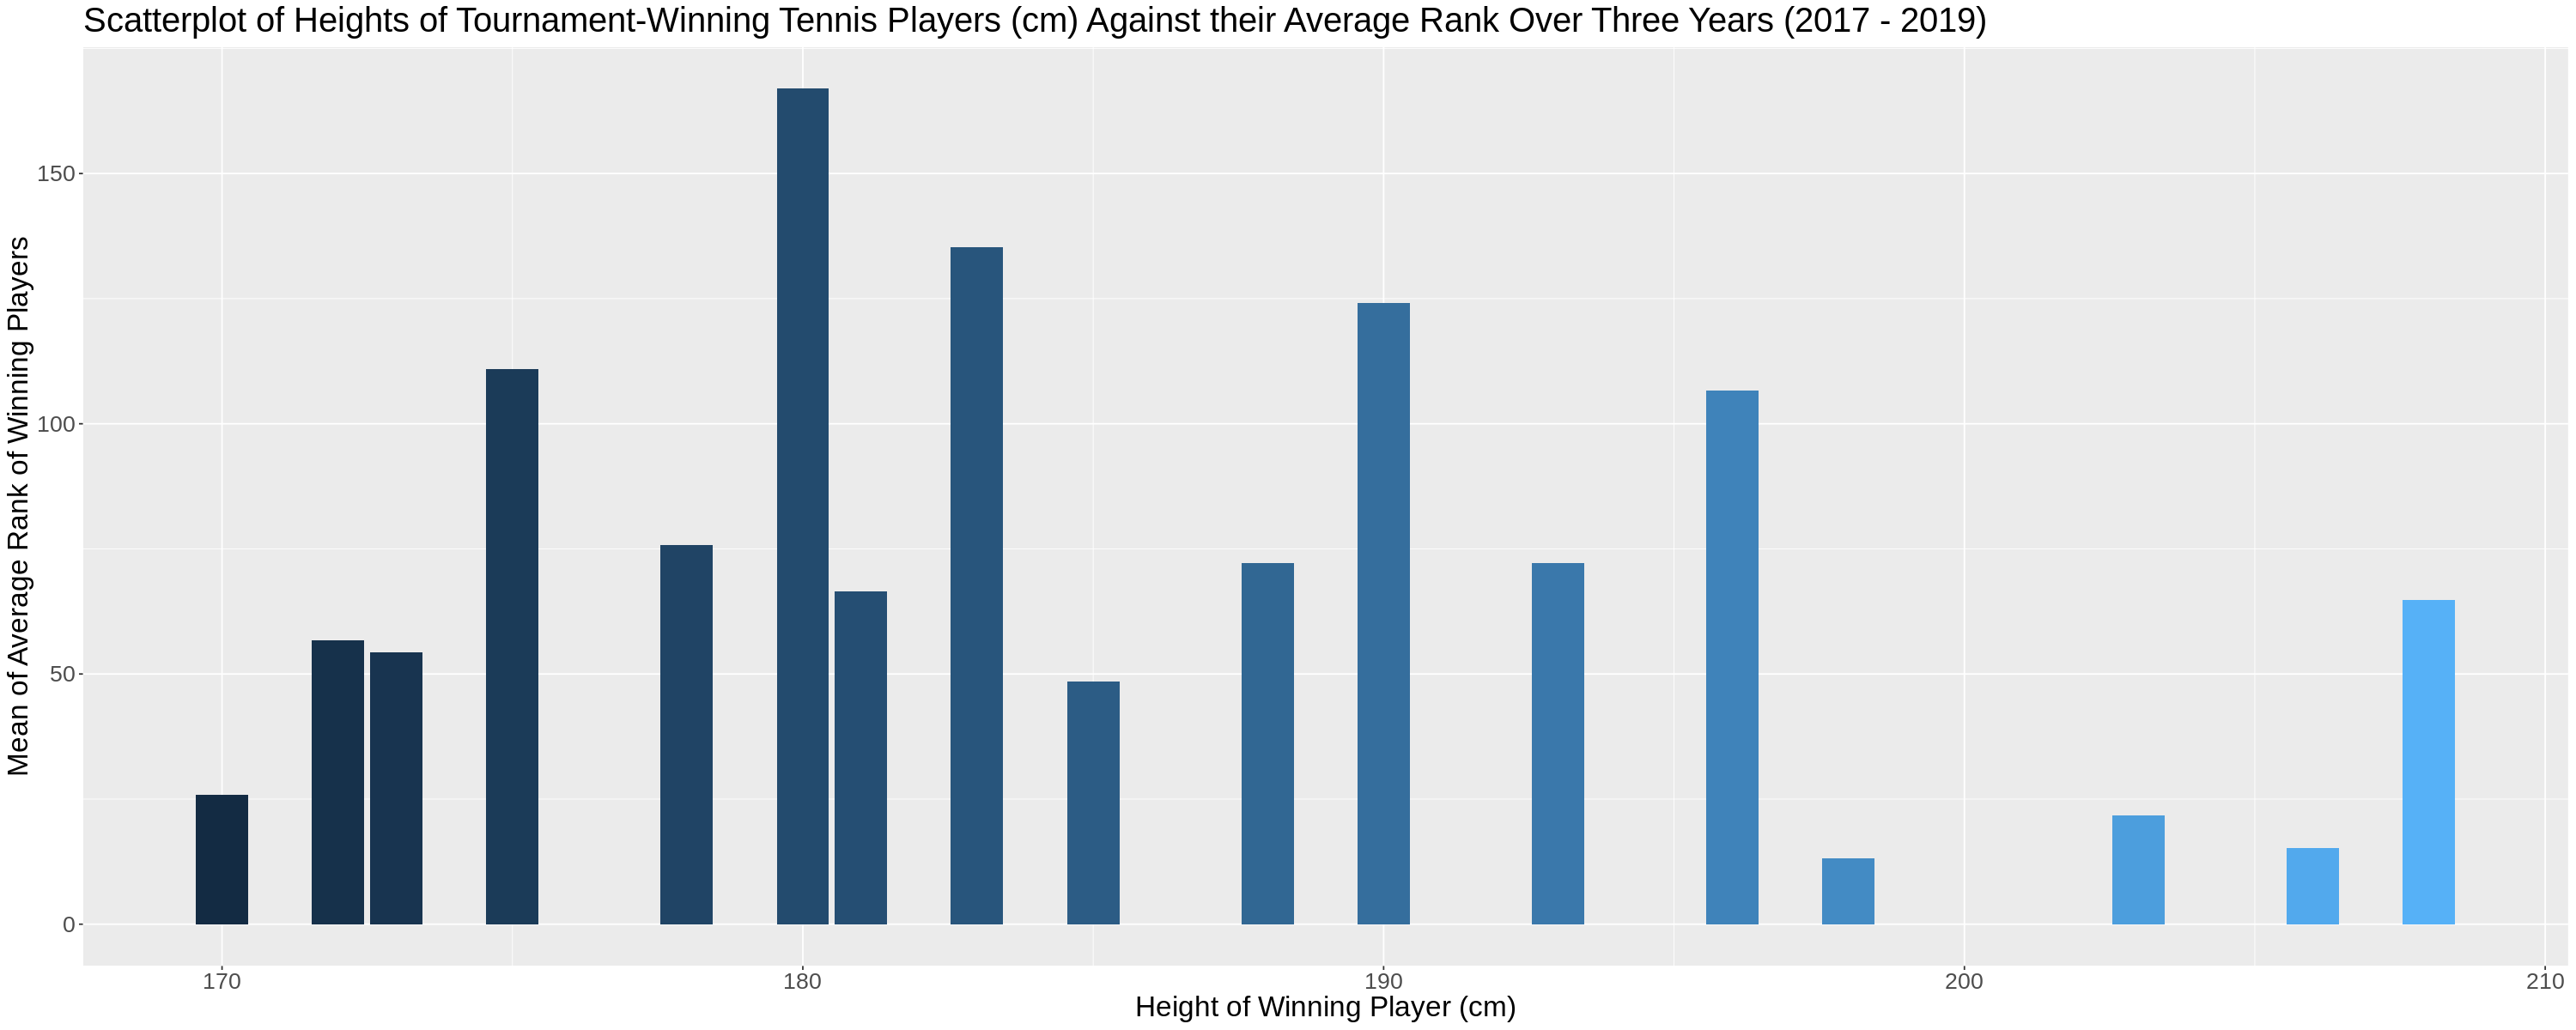

In [8]:
height_data <- data_train %>%
group_by(winner_ht) %>%
summarize(winner_avg_rank_avg = mean(winner_avg_rank))

options(repr.plot.width = 25, repr.plot.height = 10)
data_train_height_scatterplot <- height_data%>%
    ggplot(aes(x=winner_ht, y=winner_avg_rank_avg, fill = winner_ht))+
        geom_bar(stat = "identity", show.legend = FALSE)+
        labs(x="Height of Winning Player (cm)", y="Mean of Average Rank of Winning Players")+
        ggtitle("Scatterplot of Heights of Tournament-Winning Tennis Players (cm) Against their Average Rank Over Three Years (2017 - 2019)")+
        theme (text = element_text (size = 20))
data_train_height_scatterplot

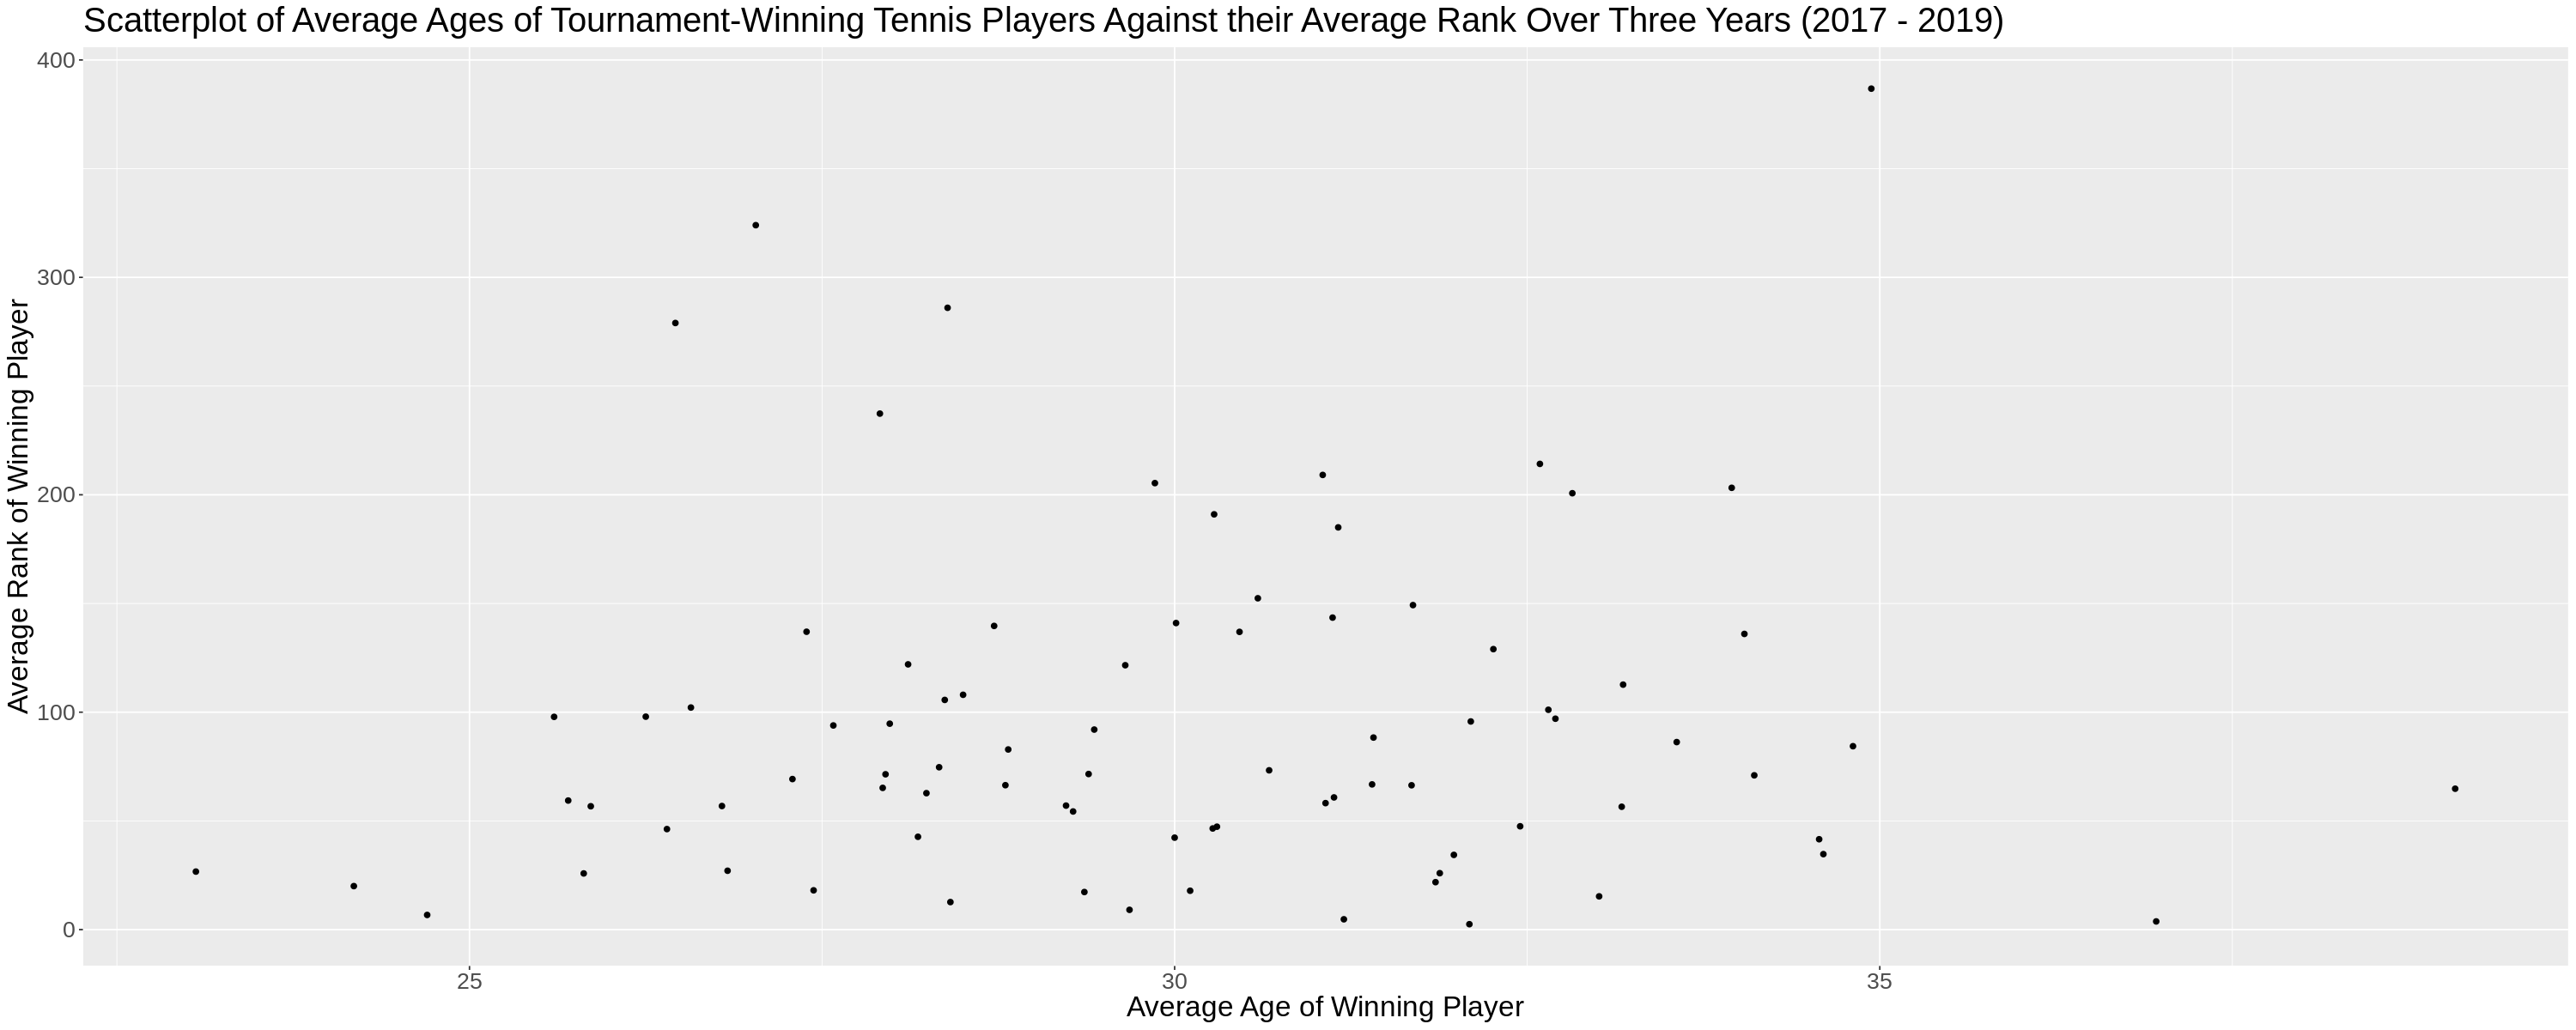

In [9]:
options(repr.plot.width = 25, repr.plot.height = 10)
data_train_age_scatterplot <- data_train%>%
    ggplot(aes(x=winner_avg_age, y=winner_avg_rank))+
        geom_point()+
        labs(x="Average Age of Winning Player", y="Average Rank of Winning Player")+
        ggtitle("Scatterplot of Average Ages of Tournament-Winning Tennis Players Against their Average Rank Over Three Years (2017 - 2019)")+
        theme (text = element_text (size = 20))
data_train_age_scatterplot

`summarise()` ungrouping output (override with `.groups` argument)



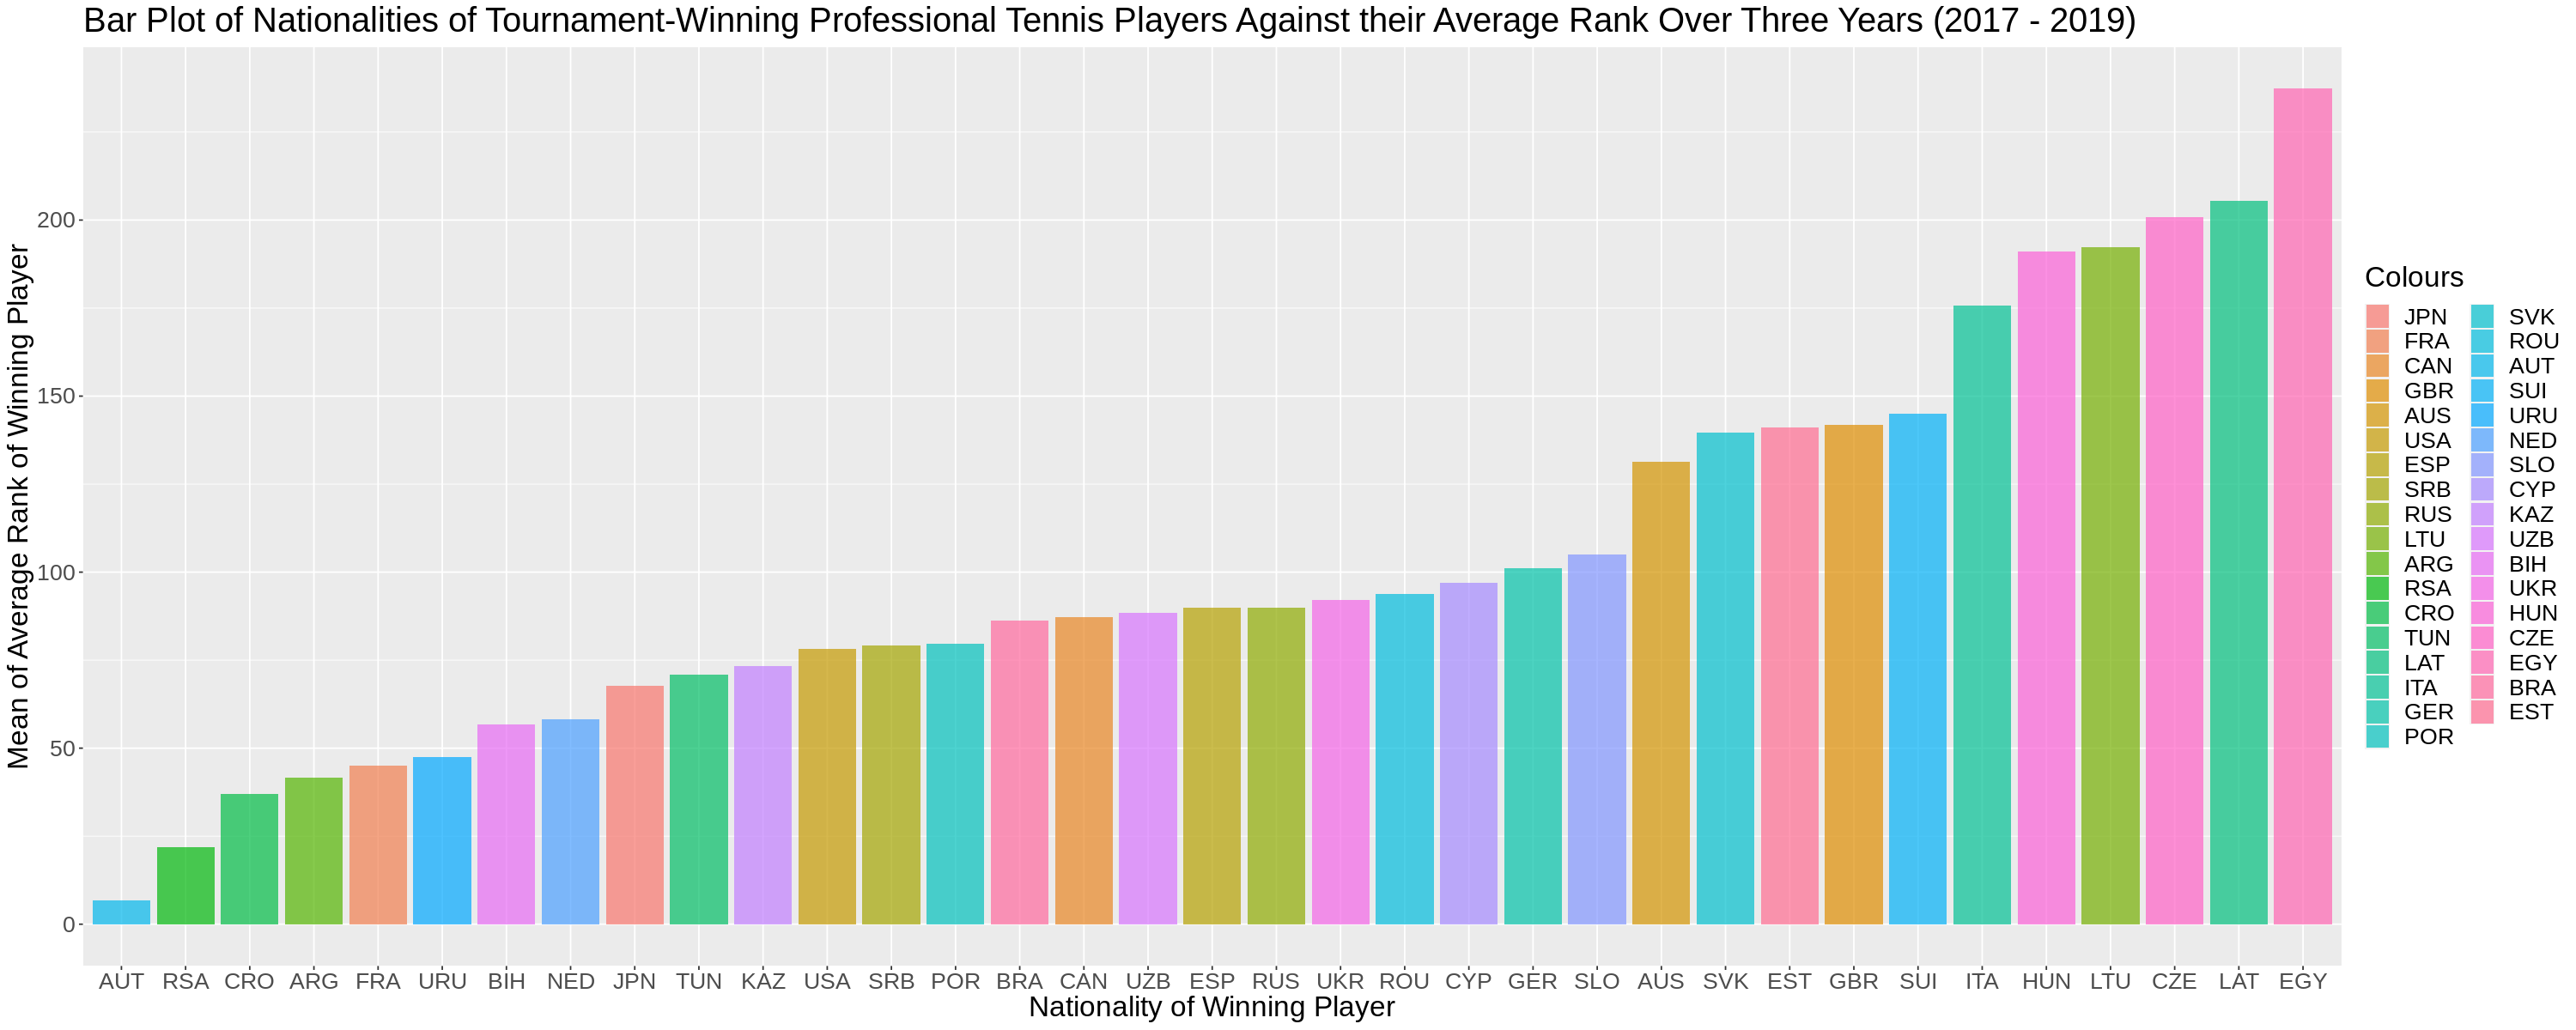

In [10]:
ioc_data <- data_train %>%
group_by(winner_ioc) %>%
summarize(winner_avg_rank_avg = mean(winner_avg_rank))

options(repr.plot.width = 25, repr.plot.height = 10)
data_train_nationality_barplot <- ioc_data %>%
    ggplot(aes(x=fct_reorder(winner_ioc, winner_avg_rank_avg, .desc = FALSE), y=winner_avg_rank_avg, fill = winner_ioc))+
        geom_bar(stat = "identity", alpha = 0.7)+
        labs(x="Nationality of Winning Player", y="Mean of Average Rank of Winning Player", fill = "Colours")+
        ggtitle("Bar Plot of Nationalities of Tournament-Winning Professional Tennis Players Against their Average Rank Over Three Years (2017 - 2019)")+
        theme (text = element_text (size = 20))
data_train_nationality_barplot

`summarise()` ungrouping output (override with `.groups` argument)



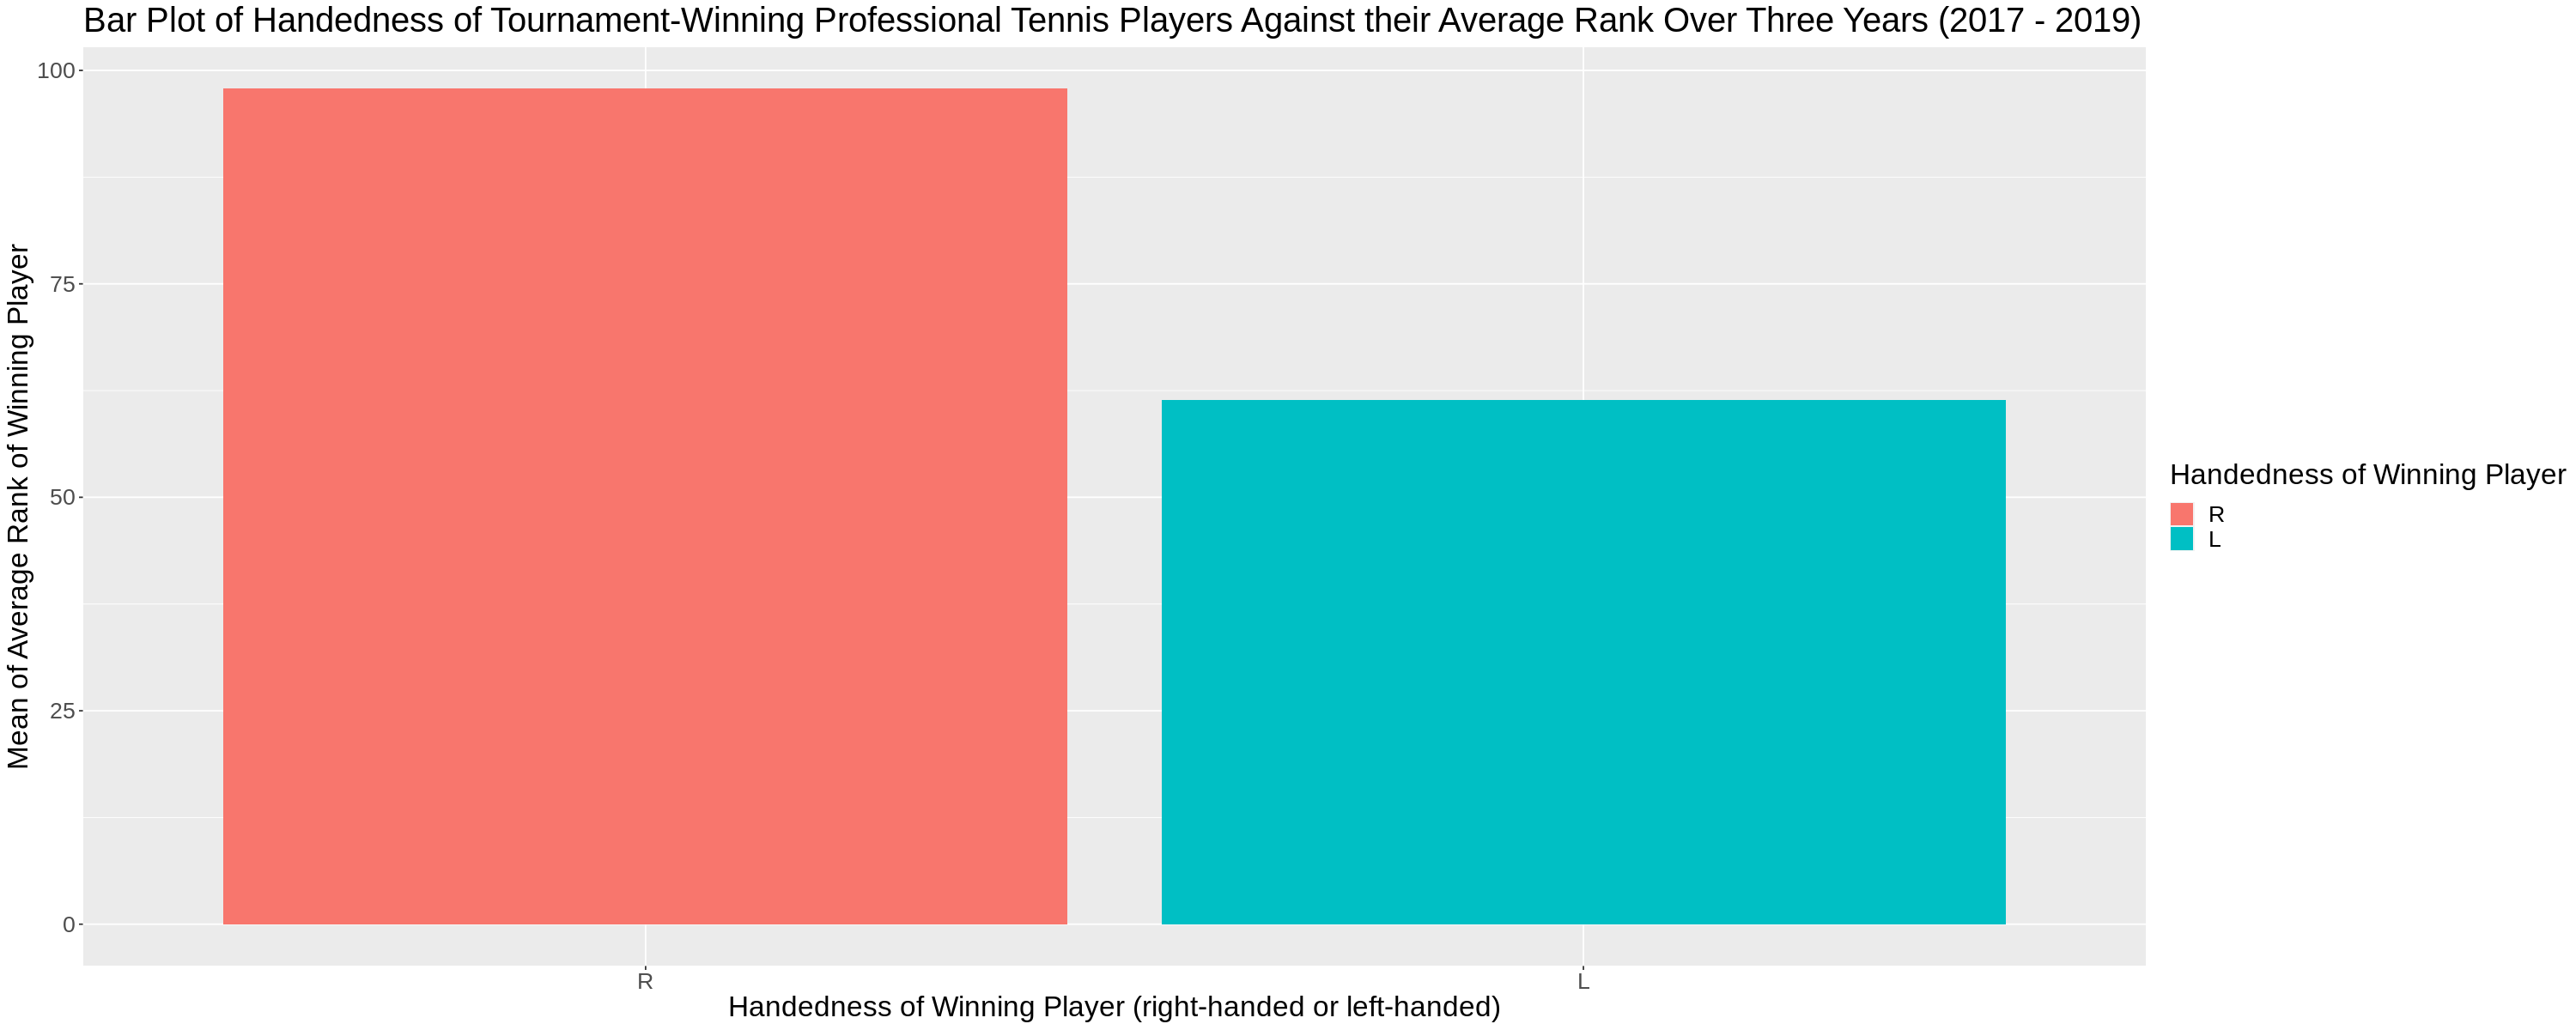

In [11]:
hand_data <- data_train %>%
group_by(winner_hand) %>%
summarize(winner_avg_rank_avg = mean(winner_avg_rank))

options(repr.plot.width = 25, repr.plot.height = 10)
data_train_hand_barplot <- hand_data %>%
    ggplot(aes(x=winner_hand, y=winner_avg_rank_avg, fill = winner_hand))+
        geom_bar(stat = "identity")+
        labs(x="Handedness of Winning Player (right-handed or left-handed)", y="Mean of Average Rank of Winning Player", fill = "Handedness of Winning Player")+
        ggtitle("Bar Plot of Handedness of Tournament-Winning Professional Tennis Players Against their Average Rank Over Three Years (2017 - 2019)")+
        theme (text = element_text (size = 20))
data_train_hand_barplot